In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import re

In [3]:
import datetime

In [4]:
import os

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from plotting import *

In [7]:
LOSS_INDEX = 3

## Acquisition

#### Directory that contains all the experiment subdirectories

In [8]:
base_dir = '../cifar10/log'

In [9]:
n_workers = 8

In [10]:
experiment_name = 'tuning_W' + str(n_workers)

In [11]:
all_matching_experiments = []

In [12]:
for directory in os.walk(base_dir):
    if directory[0].startswith(base_dir + '/'+ experiment_name):
        all_matching_experiments.append(directory[0])
print 'Found the following matching experiments : '
print '\n'.join(all_matching_experiments)

Found the following matching experiments : 
../cifar10/log/tuning_W8_2016-10-14-18:05
../cifar10/log/tuning_W8_2016-10-16-00:41


### Either let the script pick the most recent matching experiment, 

In [13]:
if len(all_matching_experiments)==0:
    print 'No experiments matching prefix ' + experiment_name
    experiment_directory = None
else:
    experiment_directory = sorted(all_matching_experiments)[-1]
    if len(all_matching_experiments)>1:
        print 'Selecting ' + experiment_directory + ' out of ' + str(len(all_matching_experiments)) + ' matching experiments.'
    else:
        print 'Selecting ' + experiment_directory 

Selecting ../cifar10/log/tuning_W8_2016-10-16-00:41 out of 2 matching experiments.


### Or manually sellect one 

In [14]:
experiment_directory='../cifar10/log/tuning_W8_2016-10-14-18:05'

### Load logs from selected experiment

In [15]:
parameter_values = {}

all_configs = []

for fname in os.listdir(experiment_directory):
    assert(fname[-4:]=='.log')
    parameter_strings = fname[:-4].split('_')
    print 'Loading ' + fname
    for pstring in parameter_strings:
        p,v = pstring.split('=')
        parameter_values[p] = float(v)
        if p=='W':
            assert(int(v)==n_workers)
    all_lines = load_results(experiment_directory + '/' + fname)
    all_configs.append([parameter_values.copy(), all_lines])

Loading W=8_G=1_LR=0.0001_mu=0.0.log
Loading W=8_G=1_LR=0.0001_mu=0.3.log
Loading W=8_G=1_LR=0.0001_mu=0.6.log
Loading W=8_G=1_LR=0.0001_mu=0.9.log
Loading W=8_G=1_LR=0.0003_mu=0.0.log
Loading W=8_G=1_LR=0.0003_mu=0.3.log
Loading W=8_G=1_LR=0.0003_mu=0.6.log
Loading W=8_G=1_LR=0.0003_mu=0.9.log
Loading W=8_G=1_LR=0.001_mu=0.0.log
Loading W=8_G=1_LR=0.001_mu=0.3.log
Loading W=8_G=1_LR=0.001_mu=0.6.log
Loading W=8_G=1_LR=0.001_mu=0.9.log
Loading W=8_G=2_LR=0.0001_mu=0.0.log
Loading W=8_G=2_LR=0.0001_mu=0.3.log
Loading W=8_G=2_LR=0.0001_mu=0.6.log
Loading W=8_G=2_LR=0.0001_mu=0.9.log
Loading W=8_G=2_LR=0.0003_mu=0.0.log
Loading W=8_G=2_LR=0.0003_mu=0.3.log
Loading W=8_G=2_LR=0.0003_mu=0.6.log
Loading W=8_G=2_LR=0.0003_mu=0.9.log
Loading W=8_G=2_LR=0.001_mu=0.0.log
Loading W=8_G=2_LR=0.001_mu=0.3.log
Loading W=8_G=2_LR=0.001_mu=0.6.log
Loading W=8_G=2_LR=0.001_mu=0.9.log
Loading W=8_G=4_LR=0.0001_mu=0.0.log
Loading W=8_G=4_LR=0.0001_mu=0.3.log
Loading W=8_G=4_LR=0.0001_mu=0.6.log
Loading W

## Plot all configs

In [16]:
W = 300

In [17]:
import matplotlib.cm as cm

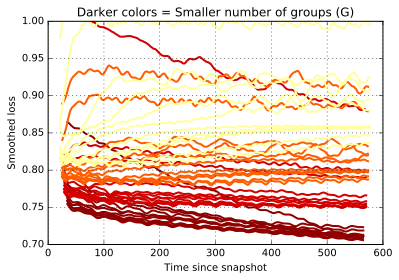

In [19]:
for config in all_configs:
    all_seconds, all_losses = get_times_losses(config[1])
    G = int(config[0]['G'])
    losses_per_batch = int(np.round(float(n_workers)/G))

    plt.plot(all_seconds, moving_average(all_losses,window_size=W*losses_per_batch),
             '-',linewidth=2, label=str(config[0]), 
             color=cm.hot((config[0]['G']+1.0)/float(n_workers+2)) )
plt.grid()
plt.axis([None, None, 0.7, 1.0]);
plt.title('Darker colors = Smaller number of groups (G)')
plt.ylabel('Smoothed loss')
plt.xlabel('Time since snapshot')

### Plots best configs per group 

In [20]:
def get_best_config_per_group(all_configs, W=500):
    #W = int(all_configs[0][0]['W'])
    best_configs = {}
    best_losses = {}
    for config in all_configs:
        G = int(config[0]['G'])
        losses_per_batch = int(np.round(float(n_workers)/G))
        Weff = W*losses_per_batch
        losses = [line[LOSS_INDEX] for line in config[1]]
        achieved_loss = min(moving_average(losses,Weff)[Weff:-Weff])
        if G not in best_configs.keys():
            best_configs[G] = [config[0].copy(), config[1]] 
            best_losses[G] = achieved_loss
        else:
            if achieved_loss < best_losses[G]:
                best_configs[G] = [config[0].copy(), config[1]] 
                best_losses[G] = achieved_loss

    return best_configs

In [21]:
best_configs = get_best_config_per_group(all_configs,W=W)

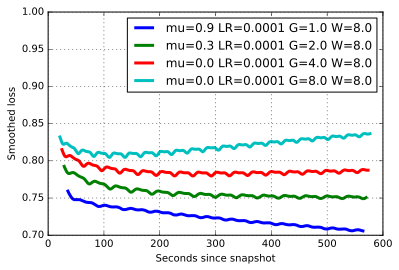

In [22]:
for G in sorted(best_configs.keys()):
    config = best_configs[G]
    all_seconds, all_losses = get_times_losses(config[1])
    losses_per_batch = int(np.round(float(n_workers)/G))
    plt.plot(all_seconds, moving_average(all_losses,window_size=W*losses_per_batch),
             '-',linewidth=3,
             label=' '.join([p+'='+str(config[0][p]) for p in config[0]])
    )
plt.xlabel('Seconds since snapshot')
plt.ylabel('Smoothed loss')
plt.legend()
plt.grid()
plt.axis([None, None, 0.7, 1.0]);

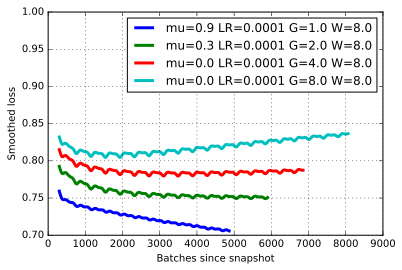

In [23]:
for G in sorted(best_configs.keys()):
    config = best_configs[G]
    all_seconds, all_losses = get_times_losses(config[1])
    losses_per_batch = int(np.round(float(n_workers)/G))
    all_batches = np.arange(len(all_losses))/losses_per_batch
    plt.plot(all_batches, moving_average(all_losses,window_size=W*losses_per_batch),
             '-',linewidth=3,
             label=' '.join([p+'='+str(config[0][p]) for p in config[0]])
    )
plt.xlabel('Batches since snapshot')
plt.ylabel('Smoothed loss')
plt.legend()
plt.grid()
plt.axis([None, None, 0.7, 1.0]);

In [24]:
n=n_workers

In [25]:
def get_he_se_numbers_from_log_lines(all_lines,n,g,group_batch=True):

    all_seconds, all_losses = get_times_losses(all_lines)

    iters =[line[2] for line in all_lines]
    
    if group_batch:
        # Each group is responsible of a mini-batch
        total_batches=g*(np.max(iters)-iters[0])
    else:
        # Each worker is responsible for a mini-batch
        total_batches=n*(np.max(iters)-iters[0])

    total_time = all_seconds[-1]

    seconds_per_batch = total_time/total_batches
    
    return seconds_per_batch, total_batches, total_time



## Set numbers of groups to focus on here

In [29]:
all_g = [1,2,4,8]

In [30]:
for G in all_g:
    print get_he_se_numbers_from_log_lines(best_configs[G][1], n_workers, G)

(0.11591050145208132, 5165, 598.67774)
(0.09642100966494846, 6208, 598.581628)
(0.08343607264361405, 7172, 598.403513)
(0.07100129748338081, 8424, 598.11493)


[None, None, 0.7, 0.9]

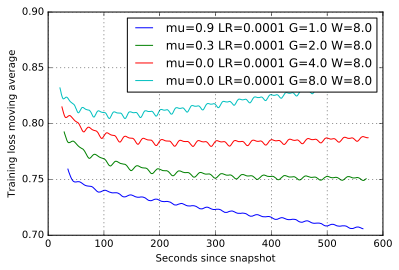

In [31]:
all_seconds_per_batch=[]
all_total_batches=[]
all_total_time=[]
for G in all_g:
    losses_per_batch = int(np.round(float(n_workers)/G))
    Weff = W*losses_per_batch
    all_lines = best_configs[G][1]
    seconds, losses = get_times_losses(all_lines)
    plt.plot(seconds,moving_average(losses,Weff),
             label=' '.join([p+'='+str(best_configs[G][0][p]) for p in best_configs[G][0]])
    )

plt.xlabel('Seconds since snapshot')
plt.ylabel('Training loss moving average')
plt.legend()
plt.grid()
plt.axis([None, None, 0.7, 0.9])

### Calculate the target loss: lowest loss achieved by all configurations

In [32]:
all_losses=[]
all_seconds=[]
max_min_loss = -np.inf
for G in all_g:
    losses_per_batch = int(np.round(float(n_workers)/G))
    all_lines = best_configs[G][1]
    seconds, losses = get_times_losses(all_lines)
    losses = moving_average(losses, W*losses_per_batch)
    all_losses.append(losses)
    all_seconds.append(seconds)
    if np.nanmin(losses)>max_min_loss:
        max_min_loss = np.nanmin(losses)
print max_min_loss

0.804604965911


### Estimate the time (in seconds) it took each configuration to reach this target loss

In [33]:
assert(not np.isinf(max_min_loss))
all_crossings =[]
for gi in range(len(all_g)):
    G=all_g[gi]
    losses_per_batch = int(np.round(float(n_workers)/G))
    Weff = W*losses_per_batch
    losses = all_losses[gi]
    seconds = all_seconds[gi]
    crossing_index = np.nonzero(losses[Weff:-Weff]<=max_min_loss)[0][0]+Weff
    crossing_time = seconds[crossing_index]
    #crossing_time = seconds[np.nonzero(losses[W:-W]<=max_min_loss)[0][0]+W]
    all_crossings.append(crossing_time)

In [34]:
all_crossings

[35.404253, 28.720118, 44.223971, 137.635998]

### Calculate how many iterations (batches) were required to reach target loss 

In [35]:
all_seconds_per_batch=[]
all_total_batches=[]
all_total_time=[]
all_batches_to_target=[]
for gi in range(len(all_g)):
    g=all_g[gi]
    spb, tb, tt = get_he_se_numbers_from_log_lines(best_configs[g][1], n_workers, g)
    #get_he_se_numbers(experiment_name,4,g)
    all_seconds_per_batch.append(spb)
    all_total_batches.append(tb)
    all_total_time.append(tt)
    all_batches_to_target.append(np.ceil(all_crossings[gi]/spb))
    

In [36]:
all_batches_to_target

[306.0, 298.0, 531.0, 1939.0]

### Hardware efficiency

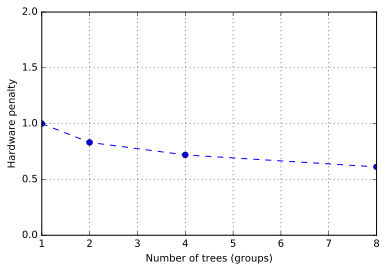

In [37]:
plt.plot(all_g,np.array(all_seconds_per_batch)/all_seconds_per_batch[0],'o--')
plt.grid()
plt.ylabel('Hardware penalty')
plt.axis([None, None, 0, 2]);
plt.xlabel('Number of trees (groups)')

In [38]:
all_seconds_per_batch

[0.11591050145208132,
 0.09642100966494846,
 0.08343607264361405,
 0.07100129748338081]

### Statistical efficiency 

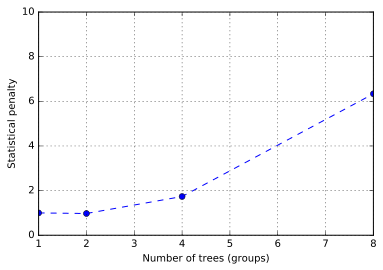

In [39]:
plt.plot(all_g,all_batches_to_target/all_batches_to_target[0], 'o--')
plt.grid()
plt.ylabel('Statistical penalty')
plt.axis([None, None, 0, 10])
plt.xlabel('Number of trees (groups)')

### Efficiency Triplet 

In [40]:
def plot_he(ax):
    ax.plot(all_g,np.array(all_seconds_per_batch)/all_seconds_per_batch[0],'o--')
    ax.grid()
    ax.set_ylabel('Hardware penalty')
    ax.axis([None, None, 0, 2]);
    ax.set_xlabel('# groups')

In [41]:
def plot_se(ax):
    ax.plot(all_g,all_batches_to_target/all_batches_to_target[0], 'o--')
    ax.grid()
    ax.set_ylabel('Statistical penalty')
    ax.axis([None, None, 0, 10])
    ax.set_xlabel('# groups')


In [42]:
def plot_relative_time(ax):
    ax.plot(all_g,np.array(all_seconds_per_batch)*np.array(all_batches_to_target)/(all_batches_to_target[0]*all_seconds_per_batch[0]), 'o--')
    ax.grid()
    ax.set_ylabel('Relative time')
    ax.axis([None, None, 0, 10])
    ax.set_xlabel('# groups')


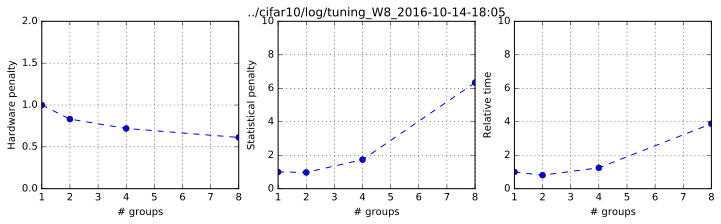

In [45]:
f,ax=plt.subplots(1,3,sharey=False, figsize=(12,3))
plot_he(ax[0])
plot_se(ax[1])
plot_relative_time(ax[2])
ax[1].set_title(experiment_directory);